In [571]:
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf
import yahooquery as yq
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from scipy import stats
from scipy import optimize
import pylab as pl
from fredapi import Fred

In [572]:
def get_data(stocks, start_date, end_date):
    stock_data = yf.download(stocks, start_date, end_date)
    stock_data = pd.DataFrame(stock_data)
    closing_prices = stock_data["Close"]
    log_returns = np.log(closing_prices.pct_change()+1)
    mean_of_returns = log_returns.mean()
    cov_of_returns = log_returns.cov()
    return log_returns , mean_of_returns, cov_of_returns



In [573]:
def portfolio_std(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [574]:
def expected_portfolio_returns(weigths, log_returns):
    return np.sum(log_returns.mean()*weigths)*100

In [575]:
def expected_mc_returns(weights, mean_returns, cov_mat, timeframe=100, sim_count=10000):
    mean_mat = np.full(shape =(timeframe, len(weights)), fill_value=mean_returns)
    mean_mat = mean_mat.T

    portfolio_sims = np.full(shape=(timeframe, sim_count),fill_value=0.0)
    initial_value = 10000

    for sim in range(0,sim_count):
        Z = np.random.normal(size=(timeframe,len(weights)))
        L = np.linalg.cholesky(cov_mat)
        daily_returns = mean_mat + np.inner(L,Z)

        portfolio_sims[:,sim] = np.cumprod(np.inner(weights, (np.exp(daily_returns)-1).T)+1)*initial_value

    expected = portfolio_sims[timeframe-1,:].mean()/initial_value
    return expected

def expected_mc_returns_reparametrized(weights, mean_returns, cov_mat, timeframe=100, sim_count=10000, Zs=None):
    mean_mat = np.full(shape =(timeframe, len(weights)), fill_value=mean_returns)
    mean_mat = mean_mat.T

    portfolio_sims = np.full(shape=(timeframe, sim_count),fill_value=0.0)
    initial_value = 10000

    for sim in range(0,sim_count):
        #Z = np.random.normal(size=(timeframe,len(weights))) # np.random.normal(size=(sim_count, timeframe,len(weights)))
        Z = Zs[sim]
        L = np.linalg.cholesky(cov_mat)
        daily_returns = mean_mat + np.inner(L,Z)

        portfolio_sims[:,sim] = np.cumprod(np.inner(weights, (np.exp(daily_returns)-1).T)+1)*initial_value

    expected = portfolio_sims[timeframe-1,:].mean()/initial_value
    return expected

In [576]:
def get_neg_sharpe(weights, log_returns,cov_mat, risk_free_rate):
    # print(weights)
    return (expected_portfolio_returns(weights, log_returns)- (1+risk_free_rate))/portfolio_std(weights,cov_mat)

    # portfolio_value = np.dot(log_returns.mean(), weights)
    # return (expected_mc_returns(weights, portfolio_value, cov_mat)- (1+risk_free_rate))/portfolio_std(weights,cov_mat)

def get_sharpe_reparametrized(weights, log_returns,cov_mat, risk_free_rate, timeframe=100, sim_count=10000, Zs=None):
    #print(weights)
    #print("Zs: ", Zs)
    # return -(expected_portfolio_returns(weights, log_returns)- (1+risk_free_rate))/portfolio_std(weights,cov_mat)
    # log_returns = np.array(log_returns)
    portfolio_value = np.dot(log_returns.mean(), weights)
    return (expected_mc_returns_reparametrized(weights, portfolio_value, cov_mat, timeframe=timeframe, sim_count=sim_count, Zs=Zs)- (1+risk_free_rate))/portfolio_std(weights,cov_mat)

In [577]:
def get_weighted_peg_inverse(stock_names):
    pegs = []
    for s in stock_names:
        t = yq.Ticker(s)
        peg = t.key_stats[s]["pegRatio"]
        pegs.append(1/peg)

    pegs = np.array(pegs)

    return pegs

In [578]:
def get_weighted_insiders(stock_names):
    earnings = []
    for s in stock_names:
        t = yq.Ticker(s)
        earning = t.key_stats[s]["heldPercentInsiders"]
        earnings.append(earning)

    earnings = np.array(earnings)
    return earnings

In [579]:
def get_weighted_profit(stock_names):
    earnings = []
    for s in stock_names:
        t = yq.Ticker(s)
        earning = t.key_stats[s]["profitMargins"]
        earnings.append(earning)

    earnings = np.array(earnings)
    return earnings

In [580]:
def get_confidence(weights, log_returns, cov_mat, risk_free_rate, insiders, peg,profit, timeframe=100, sim_count=10000, Zs=None):
    sharpe = get_sharpe_reparametrized(weights, log_returns,cov_mat, risk_free_rate, timeframe, sim_count, Zs)
    # sharpe2 = get_neg_sharpe(weights, log_returns,cov_mat,risk_free_rate)
    peg = np.dot(peg, weights)
    insiders = np.dot(insiders, weights)
    profit = np.dot(profit, weights)
    # earning_growth = np.dot(growth, weights)
    # return -sharpe
    return -(sharpe*peg*insiders*profit)

In [581]:

stock_names = ["AAPL", "TSLA", "AMZN", "GOOG", "BA", "NKE", "AMGN", "KO", "PG", "MSFT", "CRM", "JPM"]
stocks = [stock for stock in stock_names]
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=400)

log_returns, mean_returns, cov_returns = get_data(stocks, start_date, end_date)
print(log_returns.shape)
print(mean_returns.shape)
#weighted_mean_returns = np.dot(log_returns, weights)


[*********************100%%**********************]  12 of 12 completed
(275, 12)
(12,)


/tmp/ipykernel_5023/1037405980.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  log_returns = np.log(closing_prices.pct_change()+1)


In [582]:
fred = Fred(api_key="f3fea224d98377beff02b72fbe0cb196")
ten_yr_tres_rate = fred.get_series_latest_release("GS10")/100

risk_free_rate = ten_yr_tres_rate.iloc[-1]

In [583]:
# t = yq.Ticker('AAPL')
# t.financial_data

In [584]:
weights = np.ones(len(mean_returns))
weights = weights/np.sum(weights)
annual_cov_mat = cov_returns*100

portfolio_value = np.dot(mean_returns, weights)

constraints = {"type": "eq", "fun": lambda weights : np.sum(weights)- 1}
bounds = [(0,1) for stock in range(len(stock_names))]
sim_count=10000
timeframe=100
Zs = np.random.normal(size=(sim_count, timeframe, weights.size))
# print(stock_names)
# print("Zs shape: ", Zs.shape)
# print("mean returns:", mean_returns)
# print("portfolio value:", portfolio_value)

# growth = []
insiders = get_weighted_insiders(stock_names)
peg = get_weighted_peg_inverse(stock_names)
profit = get_weighted_profit(stock_names)

# optimized_weights = optimize.minimize(get_neg_sharpe, weights, args=(log_returns, annual_cov_mat,risk_free_rate), method = "SLSQP", constraints=constraints, bounds=bounds)
optimized_weights_reparamed = optimize.minimize(get_confidence, weights, args=(log_returns,annual_cov_mat,risk_free_rate, insiders, peg, profit,timeframe, sim_count, Zs), method = "SLSQP", constraints=constraints, bounds=bounds)
weights  = np.array(optimized_weights_reparamed["x"])
weights_reparamed = np.array(optimized_weights_reparamed["x"])
value_reparamed = np.array(optimized_weights_reparamed)
print(weights.shape)
print(weights)
print("reparamed:", weights_reparamed)
print("reparamed_val:", value_reparamed)


(12,)
[5.26970977e-13 3.33518070e-12 3.70529141e-01 3.61178605e-12
 3.39447594e-12 2.27844929e-12 9.86564150e-13 5.54240986e-13
 4.65782184e-13 1.87576161e-12 4.85046567e-12 6.29470859e-01]
reparamed: [5.26970977e-13 3.33518070e-12 3.70529141e-01 3.61178605e-12
 3.39447594e-12 2.27844929e-12 9.86564150e-13 5.54240986e-13
 4.65782184e-13 1.87576161e-12 4.85046567e-12 6.29470859e-01]
reparamed_val:  message: Optimization terminated successfully
 success: True
  status: 0
     fun: -2.746087321543141
       x: [ 5.270e-13  3.335e-12  3.705e-01  3.612e-12  3.394e-12
            2.278e-12  9.866e-13  5.542e-13  4.658e-13  1.876e-12
            4.850e-12  6.295e-01]
     nit: 8
     jac: [-5.094e+00 -1.264e+01 -1.655e+01 -9.026e+00  8.692e+00
           -8.239e+00 -7.509e+00 -5.394e+00 -6.212e+00 -9.493e+00
           -7.949e+00 -1.655e+01]
    nfev: 114
    njev: 8


Text(0.5, 1.0, 'Monte Carlo sim of Portfolio')

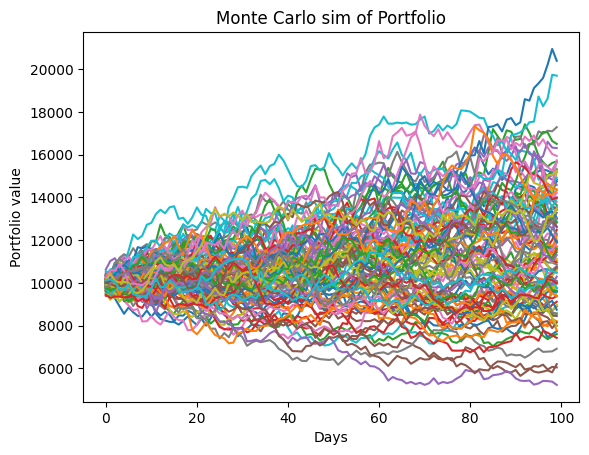

In [585]:
sim_count = 10000
timeframe = 100
mean_mat = np.full(shape =(timeframe, len(weights)), fill_value=mean_returns)
mean_mat = mean_mat.T

portfolio_sims = np.full(shape=(timeframe, sim_count),fill_value=0.0)
initial_value = 10000

for sim in range(0,sim_count):
    Z = np.random.normal(size=(timeframe,len(weights)))
    L = np.linalg.cholesky(cov_returns)
    daily_returns = mean_mat + np.inner(L,Z)

    portfolio_sims[:,sim] = np.cumprod(np.inner(weights, (np.exp(daily_returns)-1).T)+1)*initial_value


plt.plot(portfolio_sims[:,0:100])
# print(portfolio_sims)
plt.ylabel("Portfolio value")
plt.xlabel("Days")
plt.title("Monte Carlo sim of Portfolio")

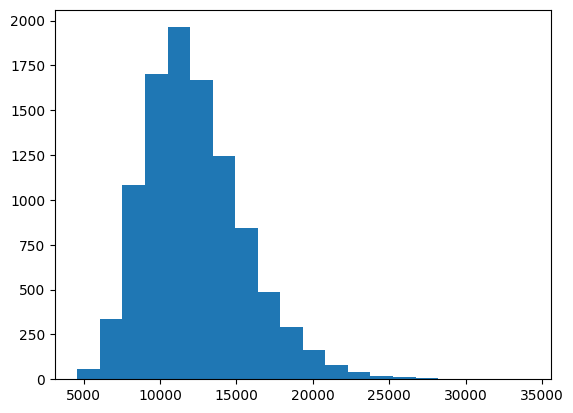

In [586]:
#analyze probability of a specific value
day = timeframe-1
values = portfolio_sims[day,:]

# fit = stats.norm.pdf(values, np.mean(values), np.std(values))

plt.hist(values, bins=20)
plt.show()

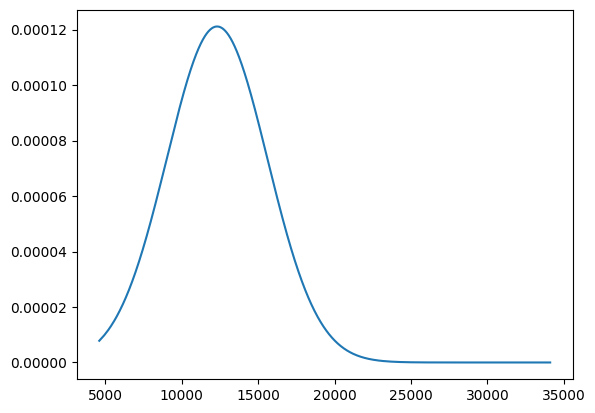

In [587]:
pdf = stats.norm.pdf(np.sort(values), np.mean(values), np.std(values))
plt.plot(np.sort(values), pdf)

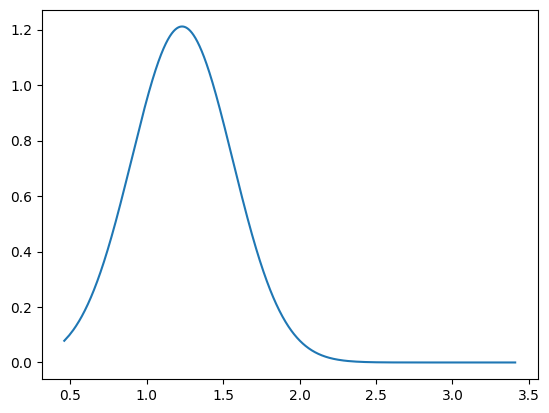

In [588]:
return_rates = values/initial_value
pdf2 = stats.norm.pdf(np.sort(return_rates), np.mean(return_rates), np.std(return_rates))
plt.plot(np.sort(return_rates), pdf2)



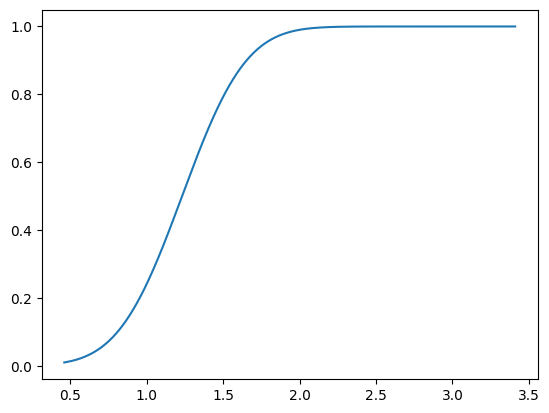

1.1873693250475266
1.6529838370221093


In [589]:
norm_cdf = stats.norm.cdf(np.sort(return_rates),np.mean(return_rates), np.std(return_rates))
sns.lineplot(x=np.sort(return_rates), y=norm_cdf)
plt.show()
print(np.percentile(return_rates,50))
print(stats.norm.ppf(0.9, np.mean(return_rates), np.std(return_rates)))

In [590]:

print((return_rates.mean()- (risk_free_rate+1))/portfolio_std(weights, cov_returns))

7.036768819788607
